In [47]:
import numpy as np
import duckdb
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [2]:
data = pd.read_csv("BDC_2024_Womens_Data.csv")

In [3]:
data.columns

Index(['Date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2'],
      dtype='object')

In [4]:
shot_attempts = duckdb.sql("""
                            SELECT Player, 
                            COUNT(Event) AS "Total Attempted",
                            COUNT (CASE WHEN Event = 'Goal' THEN 1 END) AS "Success"
                            FROM data
                            WHERE Event = 'Goal' OR Event = 'Shot'
                            GROUP BY Player
                           """).df()

shot_attempts["Success Rate"] = round(
    shot_attempts["Success"]/shot_attempts["Total Attempted"], 4)

In [5]:
shot_attempts

,Player,Total Attempted,Success,Success Rate
0,Hilary Knight,16,2,0.1250
1,Brianne Jenner,21,1,0.0476
2,Taylor Heise,16,1,0.0625
3,Alex Carpenter,15,3,0.2000
4,Megan Keller,14,1,0.0714
5,Grace Zumwinkle,3,0,0.0000
6,Marie-Philip Poulin,16,0,0.0000
7,Renata Fast,20,0,0.0000
8,Jocelyne Larocque,16,0,0.0000
9,Hannah Bilka,12,1,0.0833


In [6]:
# Another possible direction? -- What differentiates a goal vs a shot?
# Who are the good goalies of the game?

# On net but unsuccessful = goalie saved
# One-timer: a shot that occurs when a player meets a teammate's pass with an 
# immediate slapshot, without any attempt to control the puck on their stick.

# Traffic: a condensed area on the ice that has a high concentration of players 

unsuccessful_shot = duckdb.sql("""
                                SELECT Player, Event,
                               "Detail 1", "Detail 2", "Detail 3", "Detail 4"
                               FROM data
                               WHERE Event = 'Shot'
                               """).df()


unsuccessful_shot

successful_shot = duckdb.sql("""
                                SELECT Player, Event,
                               "Detail 1", "Detail 2", "Detail 3", "Detail 4"
                               FROM data
                               WHERE Event = 'Goal'
                               """).df()


# Which types of shot yield more success?
# Hypothesis Test: 
# Null Test: All types of shots have the same chances of yielding a goal.
# Alternative Test: There is a type of shot that yields goals more common

# Part 2: The Relationship Between Distance and Scoring a Goal
# By: Ying Lin Zhao

In this portion, we look to analyze the strength of the relationship between
euclidian distance and angle and scoring a goal.  

Although angle of the shot attempts were not provided, the angle at which the 
shot attempted and whether or not the shot was a goal can be cruicial. The angle
at which the shot was attempted may lead to some difference in the result. 

For the purpose of standardizing the hockey field and given the coordinate
field, we set the center of the field to be (189, 42.5). 

In [7]:
shot_distance = duckdb.sql("""
                            SELECT Player, Event,
                           "X Coordinate" AS X_Coordinate,
                           "Y Coordinate" AS Y_Coordinate
                           FROM data
                           WHERE (Event = 'Goal' OR Event = 'Shot')
                            """).df()

In [22]:
# The function will use arctangent to calculate the angle using two ordered pairs.
# Parameters: 
    # x - a vector list or single value of the x-coordinate where the shot was attempted.
    # y - a vector list or single value of the y-coordinate where the shot was attempted.
    # center_x - a float value for the x-coordinate of the orgin point
    # center_y - a float value for the y-coordinate of the orgin point
    # vector - an array or single value where the calculated values will be saved.
def angle (x, y, center_x, center_y, vector):
    assert(isinstance(center_x, float) or isinstance(center_x, int))
    assert(isinstance(center_y, float) or isinstance(center_y, int))
    y_dist = y - center_y
    x_dist = x - center_x
    for i in range(len(x_dist)):
        if (y_dist[i] == 0):
            vector[i] = 0
        elif (x_dist[i] == 0 and y_dist[i] > center_y):
            vector[i] = 0
        elif (x_dist[i] == 0 and y_dist[i] < center_y):
            vector[i] == 0
        else:
            vector[i] = abs(math.atan(y_dist[i]/x_dist[i]))


# This function uses the formula of Euclidean Distance between 2 points to calculate
# distance given points.
    # x - a vector list or single value of the x-coordinate where the shot was attempted.
    # y - a vector list or single value of the y-coordinate where the shot was attempted.
    # center_x - a float value for the x-coordinate of the orgin point
    # center_y - a float value for the y-coordinate of the orgin point
    # vector - an array or single value where the calculated values will be saved.
def euclidean_dist (x1, y1, x2, y2, vector):
    assert(isinstance(x2, float) or isinstance(x2, int))
    assert(isinstance(y2, float) or isinstance(y2, int))
    for i in range (len(x1)):
        vector[i] = np.sqrt((x1[i]-x2)**2 + (y1[i]-y2)**2)

In [23]:
angle_vector = np.zeros(len(shot_distance))

angle(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189, 42.5, angle_vector)

#print(angle_vector)
#print (shot_distance["Y Coordinate"][2])
#Currently negative angles are allowed, do we want that to be true? or all positives?
shot_distance["Shot Angle"] = angle_vector

dist_vector = np.zeros(len(shot_distance))
euclidean_dist(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189, 42.5, dist_vector)

shot_distance["Shot Distance"] = dist_vector


In [24]:
shot_distance

,Player,Event,X_Coordinate,Y_Coordinate,Shot Angle,Shot Distance,Goal
0,Hilary Knight,Goal,185,37,0.942000,6.800735,1
1,Brianne Jenner,Goal,179,51,0.704494,13.124405,1
2,Taylor Heise,Goal,175,53,0.643501,17.500000,1
3,Alex Carpenter,Goal,175,53,0.643501,17.500000,1
4,Megan Keller,Shot,129,5,0.558599,70.754858,0
...,...,...,...,...,...,...,...
418,Taylor Heise,Shot,154,41,0.042831,35.032128,0
419,Taylor Heise,Shot,170,55,0.581905,22.743131,0
420,Ella Shelton,Shot,140,36,0.131883,49.429242,0
421,Sarah Nurse,Shot,163,45,0.095859,26.119916,0


In [25]:
# Adding a binary column to the dataframe, where if event was a goal,
# then would be encoded as 1. If the event was only a shot, the entry
# would be 0. 
shot_distance["Goal"] = np.where(shot_distance["Event"] == "Goal", 1, 0)
shot_distance

X = shot_distance[["Shot Distance", "Shot Angle"]]
X = sm.add_constant(X)
y = shot_distance["Goal"]

X.corr(method = "pearson")

,const,Shot Distance,Shot Angle
const,NaN,NaN,NaN
Shot Distance,NaN,1.000000,-0.197285
Shot Angle,NaN,-0.197285,1.000000


Prior to creating a logistic regression, it is necessary to ensure there is no collinearly in the independent variables. As shown by the correlation matrix, there is no strong correlation between the shot distance and shot angle and we can proceed.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 2950)
logit_dist = sm.Logit(endog= y_train, exog= X_train).fit()

# Obtaining the estimates
dist_coef = np.round(logit_dist.params[1], 4)
angle_coef = np.round(logit_dist.params[2], 4)
logit_dist.summary()

train_predictions = logit_dist.predict(X_train)
train_predictions
print (train_predictions.shape)

y_pred = np.zeros(len(train_predictions))

for i in range (296):
    if train_predictions[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

print ("Recall is ", recall_score(y_train, y_pred))

Optimization terminated successfully.
         Current function value: 0.163204
         Iterations 9
(296,)


KeyError: 1

### Shot Distance with Goals Made
As showns by the results above, the coefficient for shot distance is approximately -0.0852 with a p-value of of 0.001. 
As the euclidean distance to the goal increases by 1 unit in the field, the odds of a goal being made is multiplied by 0.9183 or exp(-0.0852). 
This provides strong statistical evidence that there is a relationship between shot distance and whether the goal is successfully made. However, this relationship between distance and whether or not the goal is made is an extremely weak, negative one. This result demonstrates that rather than distance, other factors like speed of the puck and type of shot may matter more. As players looking to make a shot approaches the goal, it is likely that players of the opposing team will focus on the player with the puck to better defend against the shot. 

### Shot Angle with Goals Made
As for the angle of the shot, the coefficient is approximately -0.5757 with a p-value of 0.15. 
As the angle between the goal and the shot increases by 1 degree in the field, the odds of a goal being made is multiplied by 0.5623 or exp(-0.5757). 
This suggest that we fail to reject the null hypothesis that the angle does not have a relationship with whether a goal is made more not. Although, the results are not statisically significant, the coefficient being negative make sense given that the center of the goal is viewed as the 0 degrees mark. With that, as players make shot attempts near the edges rather than the middle, the challenge of angle may further hinder the chance of making a goal.

# Bigger Picture Analysis 

In a real life game, it is often difficult to isolate one single factor that determines or signifies if a shot is successful or not. As a result, in many situations, whether or not the goal is made is a combination of various factors (location, angle, personal skill, goalie, one-timer, whether or not traffic is present, etc.). Therefore, after isolating the individual factors, that is associated with shots and goals, we wanted to get the bigger picture of a game and to analyze the important factors and the statistical weight they hold.

In [43]:
analysis_df = duckdb.sql("""
                        SELECT Player, Event,
                        "X Coordinate" AS X_Coordinate, 
                        "Y Coordinate" AS Y_Coordinate, 
                         "Detail 1" AS "Shot Type",
                         "Detail 3" AS "Traffic",
                         "Detail 4" AS "One-Timer"
                         FROM data
                         WHERE (Event = 'Goal' OR Event = 'Shot')
                        """).df()

angle_a = np.zeros(len(analysis_df))
dist_a = np.zeros(len(analysis_df))

angle(analysis_df["X_Coordinate"], analysis_df["Y_Coordinate"],
                               189, 42.5, angle_a)

analysis_df["Angle (Radians)"] = angle_a

euclidean_dist(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189, 42.5, dist_a)

analysis_df["Euclid. Dist"] = dist_a

success_rate = shot_attempts[["Player", "Success Rate"]]

analysis_df = duckdb.sql("""
                        SELECT *
                        FROM analysis_df 
                        LEFT JOIN success_rate
                        ON analysis_df.Player = success_rate.Player
                        """).df()

analysis_df = analysis_df.drop(columns=["Player_2"])

# Conversion of the booleans into integer to use as binary variable
analysis_df["Traffic"].replace({"f": 0, "t": 1}, inplace=True)
analysis_df["One-Timer"].replace({"f": 0, "t": 1}, inplace=True)
# Rename Column and conversion of event to integer
analysis_df["Goal"] = np.where(analysis_df["Event"] == "Goal", 1, 0)

# Creation of dummy columns for categorical column, shot type
# Bat is dropped and is currently the reference level
shot_dummies = pd.get_dummies(analysis_df["Shot Type"], drop_first = True)
analysis_df = pd.concat([analysis_df, shot_dummies], axis = 1)


In [44]:
analysis_df

,Player,Event,X_Coordinate,Y_Coordinate,Shot Type,Traffic,One-Timer,Angle (Radians),Euclid. Dist,Success Rate,Deflection,Fan,Poke,Slapshot,Snapshot,Wrap Around,Wristshot
0,Hilary Knight,Goal,185,37,Wristshot,0,0,0.942000,6.800735,0.1250,False,False,False,False,False,False,True
1,Brianne Jenner,Goal,179,51,Wristshot,0,0,0.704494,13.124405,0.0476,False,False,False,False,False,False,True
2,Taylor Heise,Goal,175,53,Snapshot,0,1,0.643501,17.500000,0.0625,False,False,False,False,True,False,False
3,Alex Carpenter,Goal,175,53,Wristshot,0,0,0.643501,17.500000,0.2000,False,False,False,False,False,False,True
4,Megan Keller,Shot,129,5,Snapshot,0,0,0.558599,70.754858,0.0714,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Emma Maltais,Shot,184,52,Snapshot,0,0,1.086318,10.735455,0.0000,False,False,False,False,True,False,False
419,Emma Maltais,Shot,186,25,Wristshot,0,0,1.401018,17.755281,0.0000,False,False,False,False,False,False,True
420,Emma Maltais,Shot,188,47,Snapshot,0,1,1.352127,4.609772,0.0000,False,False,False,False,True,False,False
421,Emma Maltais,Shot,181,42,Deflection,0,1,0.062419,8.015610,0.0000,True,False,False,False,False,False,False


In [ ]:
X_all = analysis_df["Traffic", "One-Timer", "Angle (Radians)", "Euclid. Dist",
                    "Success Rate", "Deflection", "Fan", "Poke", "Slapshot",
                    "Wrap Around", "Wristshot"]

y_all = analysis_df["Goal"]



In [ ]:
### ALL CODE BELOW IS NOT PART OF OFFICIAL ANALYSIS, too detailed
trial_num = 1000
estimated_dist_coef = np.zeros(trial_num)
estimated_angle_coef = np.zeros(trial_num)
model_mse = np.zeros(trial_num)
for i in range (trial_num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.3)
    logit_dist = LogisticRegression().fit(X_train, y_train)
    estimated_dist_coef[i] = logit_dist.coef_[0,0]
    estimated_angle_coef[i] = logit_dist.coef_[0,1]
    predicted = logit_dist.predict(X_test)
    model_mse[i] = np.square(np.subtract(y_test, predicted)).mean()


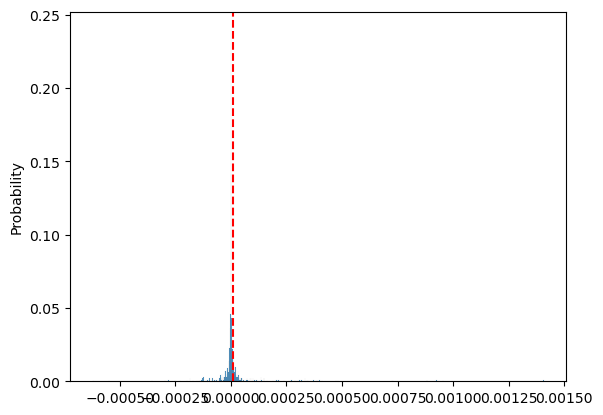

In [ ]:
mean_est_dist = np.mean(estimated_dist_coef)
dist_plot = sns.histplot(estimated_dist_coef, 
             stat = "probability")
dist_plot.axvline(x = mean_est_dist,
                  color = "red",
                  linestyle = "dashed",
                  )

<Axes: ylabel='Count'>

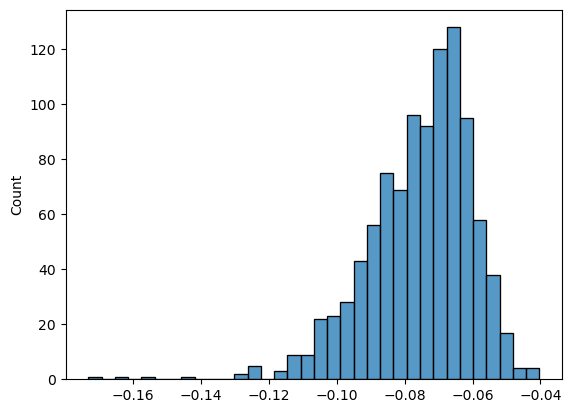

In [ ]:
sns.histplot(estimated_angle_coef)

<Axes: >

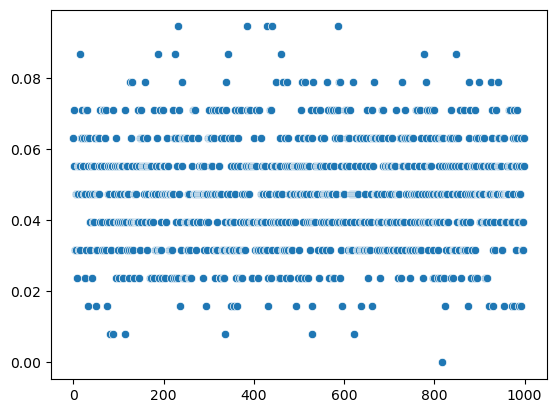

In [ ]:
sns.scatterplot(model_mse)